In [1]:
import os
import re
import geopandas as gpd
from shapely.geometry import box, Point, LineString, MultiLineString
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import rasterio

# Directory containing your tiles
tiles_dir = 'data/resampled/'  # Update this path

# Regular expression to parse tile filenames
tile_pattern = re.compile(r'^Ai2_WorldCover_10m_2024_v1_([NS])(\d{2})([EW])(\d{3})_Map\.tif$')

tile_geometries = []
tile_names = []

for filename in os.listdir(tiles_dir):
    if filename.endswith('.tif'):
        match = tile_pattern.match(filename)
        if match:
            lat_prefix, lat_str, lon_prefix, lon_str = match.groups()
            lat = int(lat_str)
            lon = int(lon_str)
            if lat_prefix == 'S':
                lat = -lat
            if lon_prefix == 'W':
                lon = -lon

            # Create a 1x1-degree box geometry for the tile
            tile_geom = box(lon, lat, lon + 1, lat + 1)
            tile_geometries.append(tile_geom)
            tile_names.append(filename)
        else:
            print(f"Filename does not match expected format: {filename}")

# Create a GeoDataFrame of tile extents
tiles_gdf = gpd.GeoDataFrame({'tile_name': tile_names, 'geometry': tile_geometries}, crs='EPSG:4326')
# Load the coastlines shapefile
coastlines_gdf = gpd.read_file('coastlines-split-4326/lines.shp')

# Ensure the coastlines are in the same CRS
if coastlines_gdf.crs != 'EPSG:4326':
    coastlines_gdf = coastlines_gdf.to_crs('EPSG:4326')


In [3]:
# Use spatial indexing for efficient intersection
tiles_sindex = tiles_gdf.sindex

def find_intersecting_tiles(geometry):
    possible_matches_index = list(tiles_sindex.intersection(geometry.bounds))
    possible_matches = tiles_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(geometry)]
    return precise_matches['tile_name'].tolist()

# Find tiles that intersect any of the coastlines
intersecting_tiles_set = set()
for idx, coastline in coastlines_gdf.iterrows():
    intersecting_tiles = find_intersecting_tiles(coastline.geometry)
    intersecting_tiles_set.update(intersecting_tiles)

# Create a GeoDataFrame of intersecting tiles
intersecting_tiles_gdf = tiles_gdf[tiles_gdf['tile_name'].isin(intersecting_tiles_set)]


In [5]:
intersecting_tiles_gdf.iloc[0]

tile_name           Ai2_WorldCover_10m_2024_v1_N70E158_Map.tif
geometry     POLYGON ((159 70, 159 71, 158 71, 158 70, 159 ...
Name: 1, dtype: object

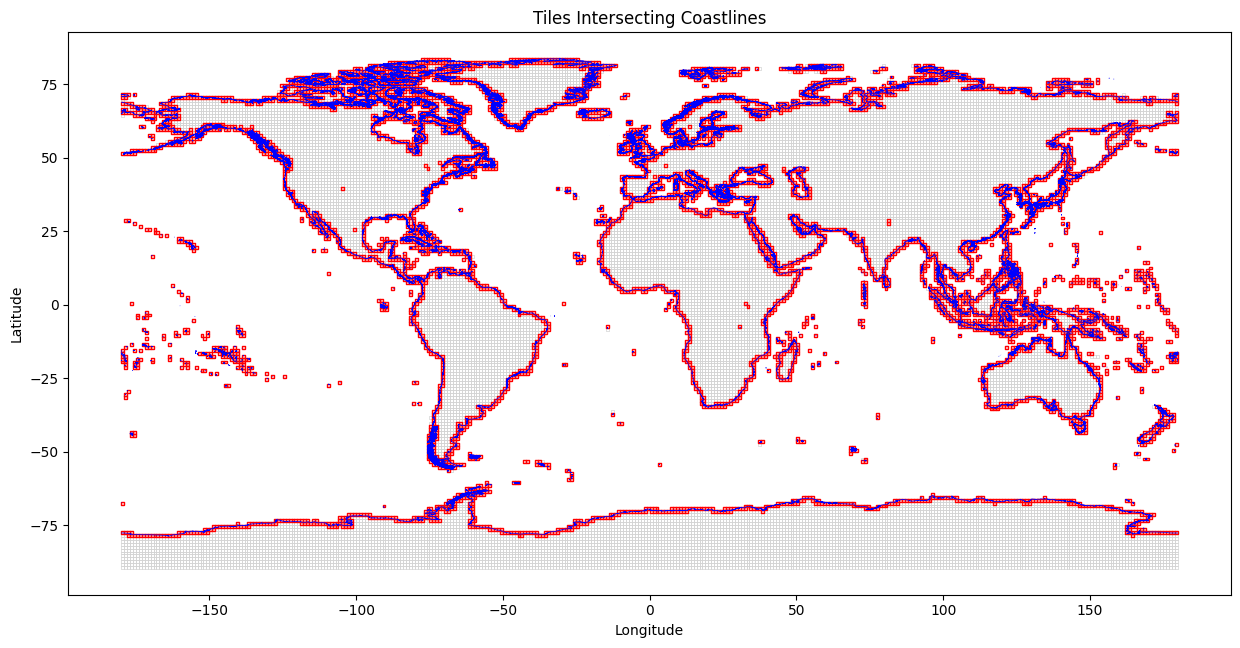

In [6]:
# Plot the tiles and coastlines
fig, ax = plt.subplots(figsize=(15, 10))
tiles_gdf.boundary.plot(ax=ax, edgecolor='lightgray', linewidth=0.5)
intersecting_tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=1)
coastlines_gdf.plot(ax=ax, color='blue', linewidth=0.5)
plt.title('Tiles Intersecting Coastlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [7]:
# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from pyproj import Geod
import numpy as np
from tqdm import tqdm

# Initialize the Geod object for WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Number of points to sample from each tile
n_points_per_tile = 10  # Adjust as needed

# Threshold length for small islands (in meters, adjust as needed)
SMALL_ISLAND_THRESHOLD = 10  # 1 km threshold

# List to collect all representative points
all_points = []

# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

def interpolate_geodesic(line, distance, geod):
    """
    Interpolates a point along a LineString at a specified geodesic distance.

    Parameters:
    - line: Shapely LineString in EPSG:4326
    - distance: Distance along the line in meters
    - geod: pyproj.Geod object

    Returns:
    - Shapely Point at the specified distance along the line
    """
    coords = list(line.coords)
    if len(coords) < 2:
        return None  # Cannot interpolate along a line with less than 2 points

    # Calculate cumulative distances between points
    cum_distances = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i - 1]
        lon2, lat2 = coords[i]
        _, _, segment_length = geod.inv(lon1, lat1, lon2, lat2)
        cum_distances.append(cum_distances[-1] + segment_length)

    # Total length of the line
    total_length = cum_distances[-1]

    # Handle edge cases
    if distance <= 0:
        return Point(coords[0])
    elif distance >= total_length:
        return Point(coords[-1])
    else:
        # Find the segment containing the desired distance
        for i in range(1, len(cum_distances)):
            if cum_distances[i] >= distance:
                # Interpolate between coords[i - 1] and coords[i]
                segment_distance = distance - cum_distances[i - 1]
                lon1, lat1 = coords[i - 1]
                lon2, lat2 = coords[i]
                fwd_azimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)
                lon_interp, lat_interp, _ = geod.fwd(lon1, lat1, fwd_azimuth, segment_distance)
                return Point(lon_interp, lat_interp)
        return None  # Should not reach here

# Loop over each intersecting tile
for idx, tile_row in tqdm(intersecting_tiles_gdf.iterrows(), total=intersecting_tiles_gdf.shape[0], desc='Processing Tiles'):
    tile_geom = tile_row.geometry
    tile_name = tile_row.tile_name

    # Get lines intersecting the tile
    lines_in_tile = get_lines_in_tile(tile_geom)
    if lines_in_tile.empty:
        continue

    # Intersect lines with the tile geometry
    lines_in_tile['geometry'] = lines_in_tile.geometry.intersection(tile_geom)
    lines_in_tile = lines_in_tile[~lines_in_tile.is_empty]

    # Combine all lines into a MultiLineString
    tile_lines = lines_in_tile.unary_union

    # Ensure tile_lines is not empty
    if tile_lines.is_empty:
        continue  # Skip if tile_lines is empty

    # Ensure we have a list of LineStrings
    if isinstance(tile_lines, LineString):
        tile_lines = [tile_lines]
    elif isinstance(tile_lines, MultiLineString):
        tile_lines = list(tile_lines.geoms)
    else:
        continue  # Skip if geometry is not LineString or MultiLineString

    # Compute total length of all lines in the tile
    total_length = 0
    line_lengths = []
    for line in tile_lines:
        lons, lats = zip(*line.coords)
        line_length = geod.line_length(lons, lats)
        line_lengths.append(line_length)
        total_length += line_length

    if total_length == 0:
        continue  # No lines to sample

    # Generate cumulative lengths
    cumulative_lengths = np.cumsum(line_lengths)

    # For short segments (below threshold), take the midpoint
    if total_length <= SMALL_ISLAND_THRESHOLD:
        midpoint = tile_lines[0].interpolate(0.5, normalized=True)
        all_points.append(midpoint)
        continue

    # Generate n_points_per_tile distances along the total length
    distances = np.linspace(0, total_length, n_points_per_tile + 2)[1:-1]  # Exclude start and end points

    # For each distance, find the corresponding point along the lines
    current_line_idx = 0
    previous_cumulative_length = 0

    for d in distances:
        # Find the line that contains this distance
        while d > cumulative_lengths[current_line_idx]:
            previous_cumulative_length = cumulative_lengths[current_line_idx]
            current_line_idx += 1
            if current_line_idx >= len(tile_lines):
                break  # Should not happen

        # Distance along the current line
        distance_along_line = d - previous_cumulative_length

        # Interpolate point along the current line at distance_along_line
        current_line = tile_lines[current_line_idx]
        point = interpolate_geodesic(current_line, distance_along_line, geod)
        if point:
            all_points.append(point)

# Create a GeoDataFrame from the list of points in `all_points`
all_points_gdf = gpd.GeoDataFrame(geometry=all_points, crs="EPSG:4326")
# Assuming all_points_gdf is the GeoDataFrame containing your points
all_points_gdf['longitude'] = all_points_gdf.geometry.x
all_points_gdf['latitude'] = all_points_gdf.geometry.y


# If the points are in a different CRS, convert to latitude/longitude (EPSG:4326)
# Replace "EPSG:32633" with the actual EPSG code of the current CRS if known
# all_points_gdf = all_points_gdf.to_crs("EPSG:4326")

# Print or use the converted points
print(all_points_gdf)


Processing Tiles: 100%|██████████| 6847/6847 [03:20<00:00, 34.08it/s]


In [39]:
from sklearn.neighbors import BallTree
# Assuming all_points_gdf is the GeoDataFrame containing your points
all_points_gdf['longitude'] = all_points_gdf.geometry.x
all_points_gdf['latitude'] = all_points_gdf.geometry.y

# Display the result with latitude and longitude columns
print(all_points_gdf[['latitude', 'longitude']])

        latitude   longitude
0      70.991470  158.137659
1      70.981401  158.229300
2      70.970833  158.320368
3      70.960898  158.412043
4      70.948057  158.499951
...          ...         ...
67803  76.557444   94.307555
67804  76.584228   94.644686
67805  76.615595   94.636146
67806  76.646149   94.983212
67807  76.710292   94.447600

[67808 rows x 2 columns]


In [44]:
# Convert coastal data to radians and create the BallTree
import joblib
coastal_data_rad = np.radians(all_points_gdf[['latitude', 'longitude']].values)
tree = BallTree(coastal_data_rad, metric='haversine')
joblib.dump(tree, 'coastal_ball_tree.joblib')


['coastal_ball_tree.joblib']

In [42]:
joblib.dump(tree, 'coastal_ball_tree.joblib')

NameError: name 'joblib' is not defined

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import linemerge
from pyproj import Geod
import numpy as np
from tqdm import tqdm

# Initialize the Geod object for WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Number of points to sample from each tile
n_points_per_tile = 10  # Adjust as needed

# List to collect all representative points
all_points = []

# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

def interpolate_geodesic(line, distance, geod):
    """
    Interpolates a point along a LineString at a specified geodesic distance.

    Parameters:
    - line: Shapely LineString in EPSG:4326
    - distance: Distance along the line in meters
    - geod: pyproj.Geod object

    Returns:
    - Shapely Point at the specified distance along the line
    """
    coords = list(line.coords)
    if len(coords) < 2:
        return None  # Cannot interpolate along a line with less than 2 points

    # Calculate cumulative distances between points
    cum_distances = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i - 1]
        lon2, lat2 = coords[i]
        _, _, segment_length = geod.inv(lon1, lat1, lon2, lat2)
        cum_distances.append(cum_distances[-1] + segment_length)

    # Total length of the line
    total_length = cum_distances[-1]

    # Handle edge cases
    if distance <= 0:
        return Point(coords[0])
    elif distance >= total_length:
        return Point(coords[-1])
    else:
        # Find the segment containing the desired distance
        for i in range(1, len(cum_distances)):
            if cum_distances[i] >= distance:
                # Interpolate between coords[i - 1] and coords[i]
                segment_distance = distance - cum_distances[i - 1]
                lon1, lat1 = coords[i - 1]
                lon2, lat2 = coords[i]
                fwd_azimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)
                lon_interp, lat_interp, _ = geod.fwd(lon1, lat1, fwd_azimuth, segment_distance)
                return Point(lon_interp, lat_interp)
        return None  # Should not reach here

# Loop over each intersecting tile
# Loop over each intersecting tile
for idx, tile_row in tqdm(intersecting_tiles_gdf.iterrows(), total=intersecting_tiles_gdf.shape[0], desc='Processing Tiles'):
    tile_geom = tile_row.geometry
    tile_name = tile_row.tile_name

    # Get lines intersecting the tile
    lines_in_tile = get_lines_in_tile(tile_geom)
    if lines_in_tile.empty:
        continue

    # Intersect lines with the tile geometry
    lines_in_tile['geometry'] = lines_in_tile.geometry.intersection(tile_geom)
    lines_in_tile = lines_in_tile[~lines_in_tile.is_empty]

    # Combine all lines into a MultiLineString
    tile_lines = lines_in_tile.unary_union

    # Ensure tile_lines is not empty
    if tile_lines.is_empty:
        continue  # Skip if tile_lines is empty

    # Ensure we have a list of LineStrings
    if isinstance(tile_lines, LineString):
        tile_lines = [tile_lines]
    elif isinstance(tile_lines, MultiLineString):
        tile_lines = list(tile_lines.geoms)
    else:
        continue  # Skip if geometry is not LineString or MultiLineString


    # Compute total length of all lines in the tile
    total_length = 0
    line_lengths = []
    for line in tile_lines:
        lons, lats = zip(*line.coords)
        line_length = geod.line_length(lons, lats)
        line_lengths.append(line_length)
        total_length += line_length

    if total_length == 0:
        continue  # No lines to sample

    # Generate cumulative lengths
    cumulative_lengths = np.cumsum(line_lengths)

    # Generate n_points_per_tile distances along the total length
    distances = np.linspace(0, total_length, n_points_per_tile + 2)[1:-1]  # Exclude start and end points

    # For each distance, find the corresponding point along the lines
    current_line_idx = 0
    previous_cumulative_length = 0

    for d in distances:
        # Find the line that contains this distance
        while d > cumulative_lengths[current_line_idx]:
            previous_cumulative_length = cumulative_lengths[current_line_idx]
            current_line_idx += 1
            if current_line_idx >= len(tile_lines):
                break  # Should not happen

        # Distance along the current line
        distance_along_line = d - previous_cumulative_length

        # Interpolate point along the current line at distance_along_line
        current_line = tile_lines[current_line_idx]
        point = interpolate_geodesic(current_line, distance_along_line, geod)
        if point:
            all_points.append(point)


Processing Tiles: 100%|██████████| 6847/6847 [03:15<00:00, 34.98it/s]


In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import linemerge
from pyproj import Geod
import numpy as np
from tqdm import tqdm

# Initialize the Geod object for WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Number of points to sample from each tile
n_points_per_tile = 10  # Adjust as needed

# List to collect all representative points
all_points = []

# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

def interpolate_geodesic(line, distance, geod):
    """
    Interpolates a point along a LineString at a specified geodesic distance.

    Parameters:
    - line: Shapely LineString in EPSG:4326
    - distance: Distance along the line in meters
    - geod: pyproj.Geod object

    Returns:
    - Shapely Point at the specified distance along the line
    """
    coords = list(line.coords)
    if len(coords) < 2:
        return None  # Cannot interpolate along a line with less than 2 points

    # Calculate cumulative distances between points
    cum_distances = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i - 1]
        lon2, lat2 = coords[i]
        _, _, segment_length = geod.inv(lon1, lat1, lon2, lat2)
        cum_distances.append(cum_distances[-1] + segment_length)

    # Total length of the line
    total_length = cum_distances[-1]

    # Handle edge cases
    if distance <= 0:
        return Point(coords[0])
    elif distance >= total_length:
        return Point(coords[-1])
    else:
        # Find the segment containing the desired distance
        for i in range(1, len(cum_distances)):
            if cum_distances[i] >= distance:
                # Interpolate between coords[i - 1] and coords[i]
                segment_distance = distance - cum_distances[i - 1]
                lon1, lat1 = coords[i - 1]
                lon2, lat2 = coords[i]
                fwd_azimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)
                lon_interp, lat_interp, _ = geod.fwd(lon1, lat1, fwd_azimuth, segment_distance)
                return Point(lon_interp, lat_interp)
        return None  # Should not reach here

# Loop over each intersecting tile
# Loop over each intersecting tile
for idx, tile_row in tqdm(intersecting_tiles_gdf.iterrows(), total=intersecting_tiles_gdf.shape[0], desc='Processing Tiles'):
    tile_geom = tile_row.geometry
    tile_name = tile_row.tile_name

    # Get lines intersecting the tile
    lines_in_tile = get_lines_in_tile(tile_geom)
    if lines_in_tile.empty:
        continue

    # Intersect lines with the tile geometry
    lines_in_tile['geometry'] = lines_in_tile.geometry.intersection(tile_geom)
    lines_in_tile = lines_in_tile[~lines_in_tile.is_empty]

    # Combine all lines into a MultiLineString
    tile_lines = lines_in_tile.unary_union

    # Ensure tile_lines is not empty
    if tile_lines.is_empty:
        continue  # Skip if tile_lines is empty

    # Ensure we have a list of LineStrings
    if isinstance(tile_lines, LineString):
        tile_lines = [tile_lines]
    elif isinstance(tile_lines, MultiLineString):
        tile_lines = list(tile_lines.geoms)
    else:
        continue  # Skip if geometry is not LineString or MultiLineString


    # Compute total length of all lines in the tile
    total_length = 0
    line_lengths = []
    for line in tile_lines:
        lons, lats = zip(*line.coords)
        line_length = geod.line_length(lons, lats)
        line_lengths.append(line_length)
        total_length += line_length

    if total_length == 0:
        continue  # No lines to sample

    # Generate cumulative lengths
    cumulative_lengths = np.cumsum(line_lengths)

    # Generate n_points_per_tile distances along the total length
    distances = np.linspace(0, total_length, n_points_per_tile + 2)[1:-1]  # Exclude start and end points

    # For each distance, find the corresponding point along the lines
    current_line_idx = 0
    previous_cumulative_length = 0

    for d in distances:
        # Find the line that contains this distance
        while d > cumulative_lengths[current_line_idx]:
            previous_cumulative_length = cumulative_lengths[current_line_idx]
            current_line_idx += 1
            if current_line_idx >= len(tile_lines):
                break  # Should not happen

        # Distance along the current line
        distance_along_line = d - previous_cumulative_length

        # Interpolate point along the current line at distance_along_line
        current_line = tile_lines[current_line_idx]
        point = interpolate_geodesic(current_line, distance_along_line, geod)
        if point:
            all_points.append(point)


Processing Tiles: 100%|██████████| 6847/6847 [03:15<00:00, 34.98it/s]


In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import linemerge
from pyproj import Geod
import numpy as np
from tqdm import tqdm

# Initialize the Geod object for WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Number of points to sample from each tile
n_points_per_tile = 10  # Adjust as needed

# List to collect all representative points
all_points = []

# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

def interpolate_geodesic(line, distance, geod):
    """
    Interpolates a point along a LineString at a specified geodesic distance.

    Parameters:
    - line: Shapely LineString in EPSG:4326
    - distance: Distance along the line in meters
    - geod: pyproj.Geod object

    Returns:
    - Shapely Point at the specified distance along the line
    """
    coords = list(line.coords)
    if len(coords) < 2:
        return None  # Cannot interpolate along a line with less than 2 points

    # Calculate cumulative distances between points
    cum_distances = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i - 1]
        lon2, lat2 = coords[i]
        _, _, segment_length = geod.inv(lon1, lat1, lon2, lat2)
        cum_distances.append(cum_distances[-1] + segment_length)

    # Total length of the line
    total_length = cum_distances[-1]

    # Handle edge cases
    if distance <= 0:
        return Point(coords[0])
    elif distance >= total_length:
        return Point(coords[-1])
    else:
        # Find the segment containing the desired distance
        for i in range(1, len(cum_distances)):
            if cum_distances[i] >= distance:
                # Interpolate between coords[i - 1] and coords[i]
                segment_distance = distance - cum_distances[i - 1]
                lon1, lat1 = coords[i - 1]
                lon2, lat2 = coords[i]
                fwd_azimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)
                lon_interp, lat_interp, _ = geod.fwd(lon1, lat1, fwd_azimuth, segment_distance)
                return Point(lon_interp, lat_interp)
        return None  # Should not reach here

# Loop over each intersecting tile
# Loop over each intersecting tile
for idx, tile_row in tqdm(intersecting_tiles_gdf.iterrows(), total=intersecting_tiles_gdf.shape[0], desc='Processing Tiles'):
    tile_geom = tile_row.geometry
    tile_name = tile_row.tile_name

    # Get lines intersecting the tile
    lines_in_tile = get_lines_in_tile(tile_geom)
    if lines_in_tile.empty:
        continue

    # Intersect lines with the tile geometry
    lines_in_tile['geometry'] = lines_in_tile.geometry.intersection(tile_geom)
    lines_in_tile = lines_in_tile[~lines_in_tile.is_empty]

    # Combine all lines into a MultiLineString
    tile_lines = lines_in_tile.unary_union

    # Ensure tile_lines is not empty
    if tile_lines.is_empty:
        continue  # Skip if tile_lines is empty

    # Ensure we have a list of LineStrings
    if isinstance(tile_lines, LineString):
        tile_lines = [tile_lines]
    elif isinstance(tile_lines, MultiLineString):
        tile_lines = list(tile_lines.geoms)
    else:
        continue  # Skip if geometry is not LineString or MultiLineString


    # Compute total length of all lines in the tile
    total_length = 0
    line_lengths = []
    for line in tile_lines:
        lons, lats = zip(*line.coords)
        line_length = geod.line_length(lons, lats)
        line_lengths.append(line_length)
        total_length += line_length

    if total_length == 0:
        continue  # No lines to sample

    # Generate cumulative lengths
    cumulative_lengths = np.cumsum(line_lengths)

    # Generate n_points_per_tile distances along the total length
    distances = np.linspace(0, total_length, n_points_per_tile + 2)[1:-1]  # Exclude start and end points

    # For each distance, find the corresponding point along the lines
    current_line_idx = 0
    previous_cumulative_length = 0

    for d in distances:
        # Find the line that contains this distance
        while d > cumulative_lengths[current_line_idx]:
            previous_cumulative_length = cumulative_lengths[current_line_idx]
            current_line_idx += 1
            if current_line_idx >= len(tile_lines):
                break  # Should not happen

        # Distance along the current line
        distance_along_line = d - previous_cumulative_length

        # Interpolate point along the current line at distance_along_line
        current_line = tile_lines[current_line_idx]
        point = interpolate_geodesic(current_line, distance_along_line, geod)
        if point:
            all_points.append(point)


Processing Tiles: 100%|██████████| 6847/6847 [03:15<00:00, 34.98it/s]


In [31]:
len(all_points)


67808

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import linemerge
from pyproj import Geod
import numpy as np
from tqdm import tqdm

# Initialize the Geod object for WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Number of points to sample from each tile
n_points_per_tile = 10  # Adjust as needed

# List to collect all representative points
all_points = []

# Prepare spatial index for coastlines
coastlines_sindex = coastlines_gdf.sindex

def get_lines_in_tile(tile_geom):
    possible_matches_index = list(coastlines_sindex.intersection(tile_geom.bounds))
    possible_matches = coastlines_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tile_geom)]
    return precise_matches

def interpolate_geodesic(line, distance, geod):
    """
    Interpolates a point along a LineString at a specified geodesic distance.

    Parameters:
    - line: Shapely LineString in EPSG:4326
    - distance: Distance along the line in meters
    - geod: pyproj.Geod object

    Returns:
    - Shapely Point at the specified distance along the line
    """
    coords = list(line.coords)
    if len(coords) < 2:
        return None  # Cannot interpolate along a line with less than 2 points

    # Calculate cumulative distances between points
    cum_distances = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i - 1]
        lon2, lat2 = coords[i]
        _, _, segment_length = geod.inv(lon1, lat1, lon2, lat2)
        cum_distances.append(cum_distances[-1] + segment_length)

    # Total length of the line
    total_length = cum_distances[-1]

    # Handle edge cases
    if distance <= 0:
        return Point(coords[0])
    elif distance >= total_length:
        return Point(coords[-1])
    else:
        # Find the segment containing the desired distance
        for i in range(1, len(cum_distances)):
            if cum_distances[i] >= distance:
                # Interpolate between coords[i - 1] and coords[i]
                segment_distance = distance - cum_distances[i - 1]
                lon1, lat1 = coords[i - 1]
                lon2, lat2 = coords[i]
                fwd_azimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)
                lon_interp, lat_interp, _ = geod.fwd(lon1, lat1, fwd_azimuth, segment_distance)
                return Point(lon_interp, lat_interp)
        return None  # Should not reach here

# Loop over each intersecting tile
# Loop over each intersecting tile
for idx, tile_row in tqdm(intersecting_tiles_gdf.iterrows(), total=intersecting_tiles_gdf.shape[0], desc='Processing Tiles'):
    tile_geom = tile_row.geometry
    tile_name = tile_row.tile_name

    # Get lines intersecting the tile
    lines_in_tile = get_lines_in_tile(tile_geom)
    if lines_in_tile.empty:
        continue

    # Intersect lines with the tile geometry
    lines_in_tile['geometry'] = lines_in_tile.geometry.intersection(tile_geom)
    lines_in_tile = lines_in_tile[~lines_in_tile.is_empty]

    # Combine all lines into a MultiLineString
    tile_lines = lines_in_tile.unary_union

    # Ensure tile_lines is not empty
    if tile_lines.is_empty:
        continue  # Skip if tile_lines is empty

    # Ensure we have a list of LineStrings
    if isinstance(tile_lines, LineString):
        tile_lines = [tile_lines]
    elif isinstance(tile_lines, MultiLineString):
        tile_lines = list(tile_lines.geoms)
    else:
        continue  # Skip if geometry is not LineString or MultiLineString


    # Compute total length of all lines in the tile
    total_length = 0
    line_lengths = []
    for line in tile_lines:
        lons, lats = zip(*line.coords)
        line_length = geod.line_length(lons, lats)
        line_lengths.append(line_length)
        total_length += line_length

    if total_length == 0:
        continue  # No lines to sample

    # Generate cumulative lengths
    cumulative_lengths = np.cumsum(line_lengths)

    # Generate n_points_per_tile distances along the total length
    distances = np.linspace(0, total_length, n_points_per_tile + 2)[1:-1]  # Exclude start and end points

    # For each distance, find the corresponding point along the lines
    current_line_idx = 0
    previous_cumulative_length = 0

    for d in distances:
        # Find the line that contains this distance
        while d > cumulative_lengths[current_line_idx]:
            previous_cumulative_length = cumulative_lengths[current_line_idx]
            current_line_idx += 1
            if current_line_idx >= len(tile_lines):
                break  # Should not happen

        # Distance along the current line
        distance_along_line = d - previous_cumulative_length

        # Interpolate point along the current line at distance_along_line
        current_line = tile_lines[current_line_idx]
        point = interpolate_geodesic(current_line, distance_along_line, geod)
        if point:
            all_points.append(point)


Processing Tiles: 100%|██████████| 6847/6847 [03:15<00:00, 34.98it/s]


In [10]:
points_gdf = gpd.GeoDataFrame(geometry=all_points)


In [ ]:
# Create a GeoDataFrame with UTM coordinates
utm_gdf = gpd.GeoDataFrame(geometry=utm_points, crs="EPSG:32633")  # Replace with the correct EPSG code for your UTM zone

# Reproject to EPSG:4326 (latitude and longitude)
latlon_gdf = utm_gdf.to_crs("EPSG:4326")

# Display the result
print(latlon_gdf)

geometry
0         POINT (465246.373 7877683.535)
1         POINT (465340.791 7877650.427)
2         POINT (465435.209 7877617.320)
3         POINT (465529.627 7877584.213)
4         POINT (465624.372 7877552.142)
...                                  ...
19848594  POINT (538633.215 8521261.504)
19848595  POINT (538639.439 8521351.255)
19848596  POINT (538710.241 8521412.060)
19848597  POINT (538774.992 8521488.250)
19848598  POINT (538835.411 8521570.815)

[19848599 rows x 1 columns]

In [13]:
import geopandas as gpd
from srai.regionalizers import VoronoiRegionalizer
from shapely.geometry import box
from tqdm import tqdm

# Assuming 'points_gdf' is your GeoDataFrame containing the seed points in EPSG:4326
print(f"After deduplication: {len(points_gdf)} unique points.")
# Check if points_gdf has a CRS
print(f"CRS before setting: {points_gdf.crs}")

# If CRS is None, set it to EPSG:4326
if points_gdf.crs is None:
    points_gdf.set_crs(epsg=4326, inplace=True)

print(f"CRS after setting: {points_gdf.crs}")
# Define the area over which to generate Voronoi regions
# Option 1: Use the bounding box of your points
minx, miny, maxx, maxy = points_gdf.total_bounds
buffer = 1.0  # Add a buffer if needed
area_geom = box(minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)
area = gpd.GeoDataFrame(geometry=[area_geom], crs=points_gdf.crs)

# Option 2: Use a predefined area (e.g., the entire world)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# area = world.unary_union
# area = gpd.GeoDataFrame(geometry=[area], crs=world.crs)

# Instantiate the VoronoiRegionalizer
regionalizer = VoronoiRegionalizer(seeds=points_gdf)

# Generate Voronoi regions with a progress bar
with tqdm(total=1, desc="Generating Voronoi regions", unit="operation") as progress:
    voronoi_regions = regionalizer.transform(area)
    progress.update(1)

print("Voronoi regions generated.")

# Optionally, visualize the regions
# voronoi_regions.plot()


After deduplication: 67880 unique points.
CRS before setting: None
CRS after setting: EPSG:4326


Generating Voronoi regions: 100%|██████████| 1/1 [12:16<00:00, 736.57s/operation]

Voronoi regions generated.


In [25]:
# output_filepath = 'voronoi_regions.parquet'

# def save_voronoi_regions(voronoi_gdf, filepath, driver='GPKG'):
#     voronoi_gdf.to_file(filepath, driver=driver)
#     print(f"Voronoi regions saved to {filepath}")


# def load_voronoi_regions(filepath):
#     voronoi_gdf = gpd.read_file(filepath)
#     print(f"Voronoi regions loaded from {filepath}")
#     return voronoi_gdf

# # Saving
# save_voronoi_regions(voronoi_regions, 'voronoi_regions.gpkg')

# # Loading
# voronoi_regions = load_voronoi_regions('voronoi_regions.gpkg')


def save_geodataframe(gdf, filepath, driver='GPKG'):
    """
    Saves a GeoDataFrame to a file.

    Parameters:
    - gdf: The GeoDataFrame to save.
    - filepath: The path to the output file.
    - driver: The file format driver ('GPKG', 'ESRI Shapefile', 'GeoJSON', etc.).
    """
    gdf.to_file(filepath, driver=driver)
    print(f"GeoDataFrame saved to {filepath}")



def load_geodataframe(filepath):
    """
    Loads a GeoDataFrame from a file.

    Parameters:
    - filepath: The path to the input file.

    Returns:
    - gdf: The loaded GeoDataFrame.
    """
    gdf = gpd.read_file(filepath)
    print(f"GeoDataFrame loaded from {filepath}")
    return gdf

# Saving the GeoDataFrame
save_geodataframe(points_gdf, 'points_gdf.gpkg', driver='GPKG')

# Loading the GeoDataFrame
points_gdf = load_geodataframe('points_gdf.gpkg')


GeoDataFrame saved to points_gdf.gpkg
GeoDataFrame loaded from points_gdf.gpkg


In [ ]:
import geopandas as gpd
from srai.regionalizers import VoronoiRegionalizer
from shapely.geometry import box
from tqdm import tqdm

# Assuming 'points_gdf' is your GeoDataFrame containing the seed points in EPSG:4326
print(f"After deduplication: {len(points_gdf)} unique points.")
# Check if points_gdf has a CRS
print(f"CRS before setting: {points_gdf.crs}")

# If CRS is None, set it to EPSG:4326
if points_gdf.crs is None:
    points_gdf.set_crs(epsg=4326, inplace=True)

print(f"CRS after setting: {points_gdf.crs}")
# Define the area over which to generate Voronoi regions
# Option 1: Use the bounding box of your points
minx, miny, maxx, maxy = points_gdf.total_bounds
buffer = 1.0  # Add a buffer if needed
area_geom = box(minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)
area = gpd.GeoDataFrame(geometry=[area_geom], crs=points_gdf.crs)

# Option 2: Use a predefined area (e.g., the entire world)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# area = world.unary_union
# area = gpd.GeoDataFrame(geometry=[area], crs=world.crs)

# Instantiate the VoronoiRegionalizer
regionalizer = VoronoiRegionalizer(seeds=points_gdf)

# Generate Voronoi regions with a progress bar
with tqdm(total=1, desc="Generating Voronoi regions", unit="operation") as progress:
    voronoi_regions = regionalizer.transform(area)
    progress.update(1)

print("Voronoi regions generated.")

# Optionally, visualize the regions
# voronoi_regions.plot()


After deduplication: 67880 unique points.
CRS before setting: None
CRS after setting: EPSG:4326


Generating Voronoi regions: 100%|██████████| 1/1 [12:16<00:00, 736.57s/operation]

Voronoi regions generated.


<Axes: >

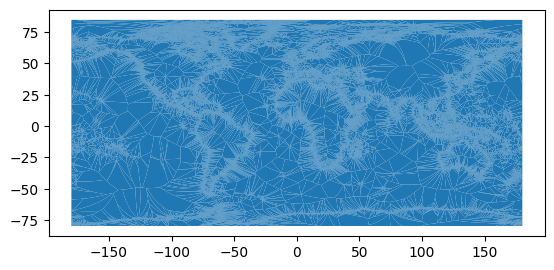

In [24]:
voronoi_regions.plot()

In [17]:
print(maxx)

179.9949649331022


In [18]:
import geopandas as gpd
from srai.regionalizers import VoronoiRegionalizer
from shapely.geometry import box
from tqdm import tqdm

# Define the area covering the entire globe
from shapely.geometry import Polygon


# Assuming 'points_gdf' is your GeoDataFrame containing the seed points in EPSG:4326
print(f"After deduplication: {len(points_gdf)} unique points.")
# Check if points_gdf has a CRS
print(f"CRS before setting: {points_gdf.crs}")

# If CRS is None, set it to EPSG:4326
if points_gdf.crs is None:
    points_gdf.set_crs(epsg=4326, inplace=True)

print(f"CRS after setting: {points_gdf.crs}")
# Define the area over which to generate Voronoi regions
# Option 1: Use the bounding box of your points
# Create a polygon representing the entire globe
area_geom = Polygon([
    (-180, -90), (-180, 90),
    (180, 90), (180, -90),
    (-180, -90)
])

area = gpd.GeoDataFrame(geometry=[area_geom], crs='EPSG:4326')
# Option 2: Use a predefined area (e.g., the entire world)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# area = world.unary_union
# area = gpd.GeoDataFrame(geometry=[area], crs=world.crs)

# Instantiate the VoronoiRegionalizer
regionalizer = VoronoiRegionalizer(seeds=points_gdf)

# Generate Voronoi regions with a progress bar
with tqdm(total=1, desc="Generating Voronoi regions", unit="operation") as progress:
    voronoi_regions = regionalizer.transform(area)
    progress.update(1)

print("Voronoi regions generated.")

# Optionally, visualize the regions
# voronoi_regions.plot()


After deduplication: 67880 unique points.
CRS before setting: EPSG:4326
CRS after setting: EPSG:4326


/home/patrickb/litus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Generating Voronoi regions: 100%|██████████| 1/1 [12:20<00:00, 740.78s/operation]

Voronoi regions generated.


In [ ]:
import geopandas as gpd
from srai.regionalizers import VoronoiRegionalizer
from shapely.geometry import box
from tqdm import tqdm

# Assuming 'points_gdf' is your GeoDataFrame containing the seed points in EPSG:4326
print(f"After deduplication: {len(points_gdf)} unique points.")
# Check if points_gdf has a CRS
print(f"CRS before setting: {points_gdf.crs}")

# If CRS is None, set it to EPSG:4326
if points_gdf.crs is None:
    points_gdf.set_crs(epsg=4326, inplace=True)

print(f"CRS after setting: {points_gdf.crs}")
# Define the area over which to generate Voronoi regions
# Option 1: Use the bounding box of your points
minx, miny, maxx, maxy = points_gdf.total_bounds
buffer = 1.0  # Add a buffer if needed
area_geom = box(minx - buffer, miny - buffer, maxx + buffer, maxy + buffer)
area = gpd.GeoDataFrame(geometry=[area_geom], crs=points_gdf.crs)

# Option 2: Use a predefined area (e.g., the entire world)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# area = world.unary_union
# area = gpd.GeoDataFrame(geometry=[area], crs=world.crs)

# Instantiate the VoronoiRegionalizer
regionalizer = VoronoiRegionalizer(seeds=points_gdf)

# Generate Voronoi regions with a progress bar
with tqdm(total=1, desc="Generating Voronoi regions", unit="operation") as progress:
    voronoi_regions = regionalizer.transform(area)
    progress.update(1)

print("Voronoi regions generated.")

# Optionally, visualize the regions
# voronoi_regions.plot()


After deduplication: 67880 unique points.
CRS before setting: None
CRS after setting: EPSG:4326


Generating Voronoi regions: 100%|██████████| 1/1 [12:16<00:00, 736.57s/operation]

Voronoi regions generated.


<Axes: >

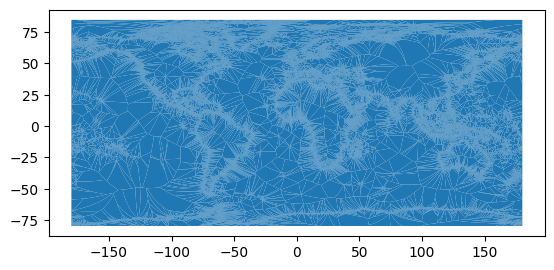

In [14]:
voronoi_regions.plot()

In [1]:
import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

from shapely.geometry import MultiPoint, Point
from shapely.ops import voronoi_diagram

from srai.regionalizers import VoronoiRegionalizer, geocode_to_region_gdf


In [6]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

def plot_flat(
    seeds_gdf: gpd.GeoDataFrame,
    regions_gdf: gpd.GeoDataFrame,
    marker_size: float = None,
    title: str = None,
) -> None:
    fig, ax = plt.subplots(figsize=(20, 10))
    world.plot(ax=ax, alpha=0.6, color="grey")
    regions_gdf.reset_index().plot(
        ax=ax, alpha=0.4, column="region_id", edgecolor="black", linewidth=0.5
    )
    seeds_gdf.plot(ax=ax, alpha=0.6, color="black", markersize=marker_size)
    ax.set_axis_off()
    fig.tight_layout()
    if title:
        plt.title(title)
    plt.show()


def plot_on_globe(
    seeds_gdf: gpd.GeoDataFrame,
    regions_gdf: gpd.GeoDataFrame,
    lon: float,
    lat: float,
    zoom: float = 1,
    marker_size: float = 5,
    title: str = None,
) -> None:
    fig = px.choropleth(
        regions_gdf,
        geojson=regions_gdf.geometry,
        locations=regions_gdf.index,
        color=regions_gdf.index,
        color_continuous_scale=px.colors.qualitative.Bold,
    )
    fig2 = px.scatter_geo(seeds_gdf, lat=seeds_gdf.geometry.y, lon=seeds_gdf.geometry.x)
    fig.update_traces(marker={"opacity": 0.4}, selector=dict(type="choropleth"))
    fig.add_trace(fig2.data[0])
    fig.update_traces(
        marker_color="black", marker_size=marker_size, selector=dict(type="scattergeo")
    )
    fig.update_layout(coloraxis_showscale=False)
    fig.update_geos(
        projection_type="orthographic",
        projection_rotation_lon=lon,
        projection_rotation_lat=lat,
        showlakes=False,
        projection_scale=zoom,
    )
    fig.update_layout(
        height=800, width=800, margin={"r": 15, "t": 15, "l": 15, "b": 15}
    )
    if title:
        fig.update_layout(title=dict(text=title, automargin=True, x=0.5))
    fig.show(renderer="png")  # replace with fig.show() to allow interactivity

In [21]:
def save_voronoi_regions(voronoi_gdf, filepath, driver='GPKG'):
    voronoi_gdf.to_file(filepath, driver=driver)
    print(f"Voronoi regions saved to {filepath}")


def load_voronoi_regions(filepath):
    voronoi_gdf = gpd.read_file(filepath)
    print(f"Voronoi regions loaded from {filepath}")
    return voronoi_gdf

# Saving
save_voronoi_regions(voronoi_regions, 'voronoi_regions.gpkg')

# Loading
voronoi_regions = load_voronoi_regions('voronoi_regions.gpkg')


def save_geodataframe(gdf, filepath, driver='GPKG'):
    """
    Saves a GeoDataFrame to a file.

    Parameters:
    - gdf: The GeoDataFrame to save.
    - filepath: The path to the output file.
    - driver: The file format driver ('GPKG', 'ESRI Shapefile', 'GeoJSON', etc.).
    """
    gdf.to_file(filepath, driver=driver)
    print(f"GeoDataFrame saved to {filepath}")



def load_geodataframe(filepath):
    """
    Loads a GeoDataFrame from a file.

    Parameters:
    - filepath: The path to the input file.

    Returns:
    - gdf: The loaded GeoDataFrame.
    """
    gdf = gpd.read_file(filepath)
    print(f"GeoDataFrame loaded from {filepath}")
    return gdf

# # Saving the GeoDataFrame
save_geodataframe(points_gdf, 'points_gdf.gpkg', driver='GPKG')

# Loading the GeoDataFrame
points_gdf = load_geodataframe('points_gdf.gpkg')


Voronoi regions saved to voronoi_regions.gpkg
Voronoi regions loaded from voronoi_regions.gpkg
GeoDataFrame saved to points_gdf.gpkg
GeoDataFrame loaded from points_gdf.gpkg


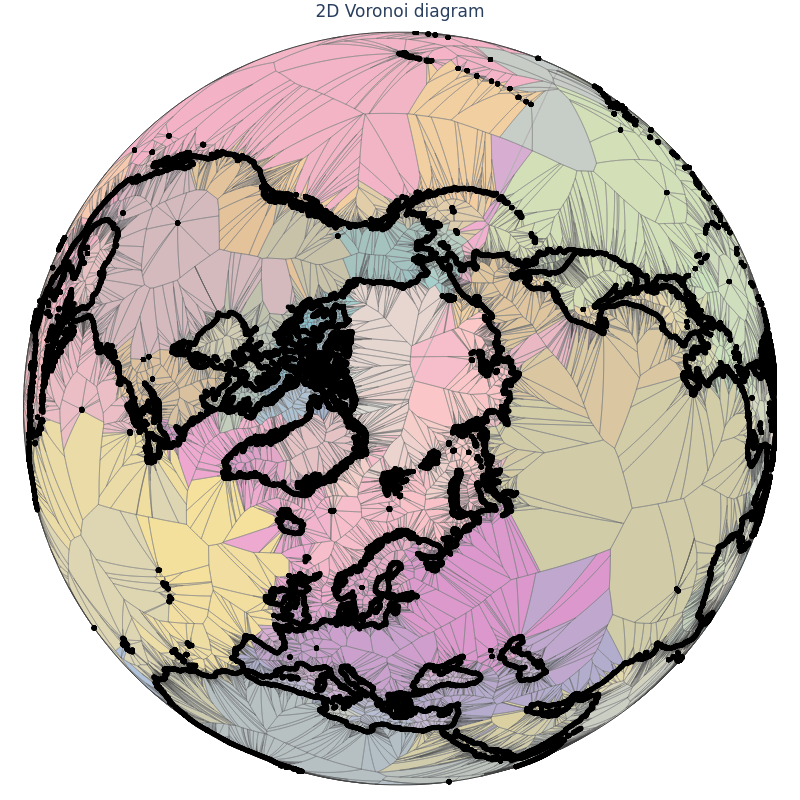

In [22]:
plot_on_globe(
    points_gdf,
    voronoi_regions,
    lon=25,
    lat=90,
    title="2D Voronoi diagram",
)

In [ ]:
plot_on_globe(
    points_gdf,
    voronoi_regions,
    lon=15,
    lat=-90,
    title="Spherical Voronoi diagram",
)

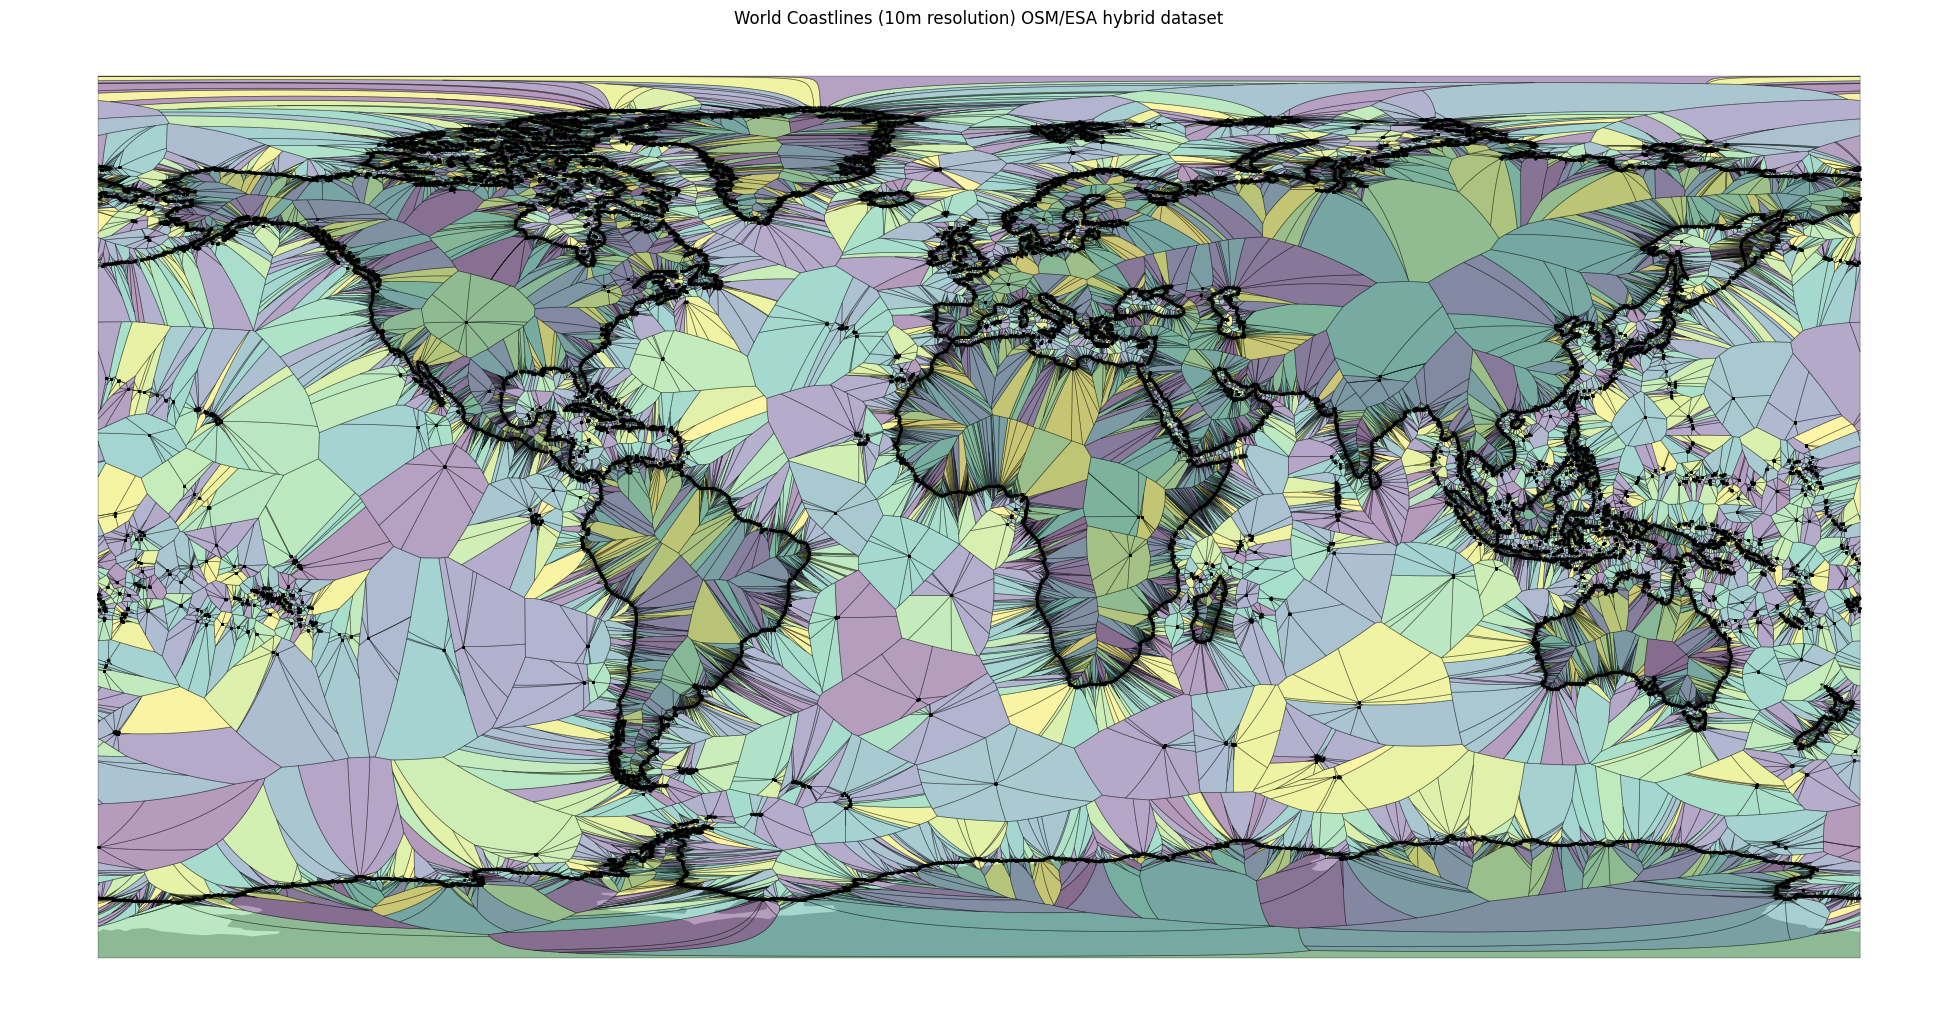

In [20]:
plot_flat(
    points_gdf,
    voronoi_regions,
    marker_size=1,
    title="World Coastlines (10m resolution) OSM/ESA hybrid dataset",
)